In [1]:
# General imports
import pickle
from pathlib import Path
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
import time
from itertools import product

import warnings
warnings.filterwarnings('ignore')

# Pytorch imports
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

from utils.plot import plot_results_hist, plot_training_results, plot_test_episodes, plot_n_training
from agents.dqn import experienceReplayBuffer, DQN_NN, DQNAgent
from agents.random import randAgent

from copy import deepcopy

In [8]:
class NoisyLinear(nn.Linear):
    ''' Noisy linear module for NoisyNet'''
    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super().__init__(in_features, out_features, bias=bias)
        self.sigma_init = sigma_init
        self.sigma_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('epsilon_weight', torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.Tensor(out_features))
            self.register_buffer('epsilon_bias', torch.zeros(out_features))
        self.reset_parameters()


    def reset_parameters(self):
        '''
        Initialize the biases and weights
        '''
        if hasattr(self, 'sigma_bias'):
            nn.init.constant_(self.sigma_bias, self.sigma_init)
            nn.init.constant_(self.sigma_weight, self.sigma_init)

        std = np.sqrt(3/self.in_features)
        nn.init.uniform_(self.weight, -std, std)
        nn.init.uniform_(self.bias, -std, std)


    def forward(self, input):
        if self.bias is not None:
            ## NB: in place operation. PyTorch is not happy with that!! CHANGE IT
            self.epsilon_bias.data.normal_()

            # new bias with noise
            bias = self.bias + self.sigma_bias*self.epsilon_bias
        else:
            bias = self.bias

        ## NB: in place operation. PyTorch is not happy with that!! CHANGE IT
        self.epsilon_weight.data.normal_()
        # new weight with noise
        weight = self.weight + self.sigma_weight*self.epsilon_weight
        # create the linear layer it the added noise
        return F.linear(input, weight, bias)

In [9]:
class NoisyDQN_NN(nn.Module):
    '''Class for the DQN neural network'''
    def __init__(self, n_inputs, n_hl1, n_hl2, n_outputs, noisyNet=False):
        super().__init__()
        """
        Params
        ======
        n_inputs: number of inputs
        n_hl1: number of units in the first hidden layer
        n_hl2: number of units in the second hidden layer
        n_outputs: number of outputs
        """
        self.n_inputs = n_inputs
        self.n_hl1 = n_hl1
        self.n_hl2 = n_hl2
        self.n_outputs = n_outputs
        self.noisyNet = noisyNet
        
        if self.noisyNet:
            self.fc1 = nn.Sequential(
                NoisyLinear(self.n_inputs, self.n_hl1),
                nn.ReLU(),
                NoisyLinear(self.n_hl1, self.n_hl2),
                nn.ReLU(),
                NoisyLinear(self.n_hl2, self.n_outputs)
            )
        else:
            self.fc1 = nn.Sequential(
                nn.Linear(self.n_inputs, self.n_hl1),
                nn.ReLU(),
                nn.Linear(self.n_hl1, self.n_hl2),
                nn.ReLU(),
                nn.Linear(self.n_hl2, self.n_outputs)
            )


    def forward(self, x):
        '''Forward pass through the network'''
        return self.fc1(x)
    
    
    def get_qvals(self, state):
        '''Returns the q-values for a given state'''
        if state.dim == 1:
            state = torch.unsqueeze(state, 0)
        return self.forward(state)
    

In [10]:
class NoisyDQNAgent:
    '''Class for the DQN agent'''
    def __init__(self, env, network, buffer, writer=None, noisyNet=False,
                 device=torch.device('cpu'), gamma=0.99, lr=0.001):
        """"
        Params
        ======
        env: environment
        network: neural network
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        eps_min: minimum epsilon
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        device: dispositivo
        actions: array de acciones posibles
        """

        self.env = env
        self.main_network = network
        self.target_network = deepcopy(network)
        
        self.buffer = buffer
        self.writer = writer
        self.gamma = gamma
        self.nblock = 100
        self.device = device
        self.noisyNet = noisyNet
        
        # Action space
        self.actions = [i for i in range(self.env.action_space.n)]
        
        # Set optimizer for the main network
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=lr)
        
        # Initialize
        self.update_loss = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]
        
    
    ### e-greedy method
    def get_action(self, state, epsilon=0.0):
        '''Return an action using an epsilon-greedy policy if not noisyNet, otherwise use a greedy policy.
             Params
            ======
            state (array_like): current state
            epsilon (float): epsilon, for epsilon-greedy action selection
        '''
        
        if not self.noisyNet and (np.random.random() < epsilon):
            action = np.random.choice(self.actions)
        else:
            state = torch.Tensor(state).unsqueeze(0).to(self.device)
            self.main_network.eval()
            with torch.inference_mode():
                qvals = self.main_network(state)
            self.main_network.train()
            action= torch.argmax(qvals, dim=-1).cpu().item()
        return action


    def take_step(self, eps, mode='train'):
        # Get random action
        if mode == 'explore':
            action = self.env.action_space.sample()  
        # Get action from q-values
        else:
            action = self.get_action(self.state0, eps)
            self.step_count += 1

        # Take step in environment
        new_state, reward, done, _, _ = self.env.step(action)
        self.total_reward += reward
        
        # Save experience in buffer
        self.buffer.append(self.state0, action, reward, done, new_state) 
        self.state0 = new_state
        return done


    def train(self, max_episodes=5000, min_episodios=250, 
              batch_size=32, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              dnn_update_frequency=4, dnn_sync_frequency=1000,
              reward_threshold=None) -> dict:
        
        self.batch_size = batch_size
        
        # Select reward threshold
        if not reward_threshold:
            reward_threshold = self.env.spec.reward_threshold
            
        # Initialize epsilon
        epsilon = eps_start
        
        # Initialize lists for tracking progress
        train_rewards = []
        train_mean_rewards = []
        train_epsilons = []
        train_losses = []
        
        # Fill the replay buffer with random experiences
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(epsilon, mode='explore')
        
        # Training loop
        episode, training = 0, True
        pbar = tqdm(desc='Training', total=max_episodes)
        
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            pbar.update(1)
            
            # Play an episode
            for t in range(self.env.spec.max_episode_steps):
                # Take action in train mode (epsilon-greedy policy)
                gamedone = self.take_step(epsilon, mode='train')
                # Update the main network
                if not self.step_count % dnn_update_frequency:
                    self.update()
                # Target and main network syncronization
                if not self.step_count % dnn_sync_frequency:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                if gamedone:
                    break

            episode += 1
            
            # Save epsilon, loss, training reward and mean training reward
            train_rewards.append(self.total_reward)
            train_epsilons.append(epsilon)
            ep_loss = np.mean(np.array(self.update_loss))
            mean_rewards = np.mean(train_rewards[-self.nblock:])
            train_losses.append(ep_loss)
            train_mean_rewards.append(mean_rewards)
            
            # Add to tensorboard
            if self.writer is not None:
                self.writer.add_scalar("epsilon", epsilon, episode)
                self.writer.add_scalar("loss", ep_loss, episode)
                self.writer.add_scalar("reward", self.total_reward, episode)
                self.writer.add_scalar("mean_reward", mean_rewards, episode)
            
            self.update_loss = []

            print(f"\rEpisode {episode} Mean Rewards {mean_rewards:.2f} Epsilon {epsilon:.2f}\t\t", end="")

            # Check if the episode limit has been reached
            if episode >= max_episodes:
                training = False
                print('Episode limit reached.')
                break

            # Finishes the game if the average reward has reached the threshold set for this game and
            # a minimum number of episodes have been played
            if mean_rewards >= reward_threshold and min_episodios < episode:
                training = False
                print(f'Environment solved in {episode} episodes!')
                break

            # Epsilon update
            epsilon = max(epsilon * eps_decay, eps_end)
            
        training_stats = {
            'training_epsilons': np.array(train_epsilons),
            'training_rewards': np.array(train_rewards),
            'mean_training_rewards': np.array(train_mean_rewards),
            'training_losses': np.array(train_losses)
        }
            
        return training_stats


    def calculate_loss(self, batch):
        # We extract the states, actions, rewards, dones and next_states from the batch
        states, actions, rewards, dones, next_states = batch
        # Get q-values for all actions in current states
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions)
        # Get max q-values for next states from target network
        qvals_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        # Q-vals to 0 in terminal states
        qvals_next[dones] = 0
        # Bellman equation
        expected_qvals = self.gamma * qvals_next + rewards
        # Loss calculation
        loss = F.mse_loss(qvals, expected_qvals.reshape(-1,1))
        return loss


    def update(self):
        # Reset gradients
        self.optimizer.zero_grad()
        # Take a random batch from the buffer
        batch = self.buffer.sample_batch(batch_size=self.batch_size, device=self.device)
        # Calculate loss
        loss = self.calculate_loss(batch)
        # Backpropagate loss
        loss.backward()
        # Update network weights with gradients
        self.optimizer.step()
        # Save loss
        self.update_loss.append(loss.detach().to('cpu').item())

In [13]:
LR = 0.001            #Velocidad de aprendizaje
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
BURN_IN = 1000        #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MAX_EPISODES = 1000   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
MIN_EPISODES = 250    #Número mínimo de episodios en los que se tiene que entrenar el agente

EPSILON_START = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
EPSILON_END = 0.01    #Valor mínimo de epsilon
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman

BATCH_SIZE = 64       # Batch size

DNN_UPD = 2          #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 100       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

N_NEURONS = 128       # Number of neurons in the hidden layers

# Set environment
env = gym.make("LunarLander-v2", render_mode='rgb_array')

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# SummaryWriter to send to TensorBoard
writer = SummaryWriter(Path('runs') / 'NoisyDQN' / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Define agent's memory replay buffer
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Define network
net = NoisyDQN_NN(n_inputs=env.observation_space.shape[0], n_hl1=N_NEURONS, n_hl2=N_NEURONS, 
             n_outputs=env.action_space.n, noisyNet=True).to(device)
writer.add_graph(net, torch.Tensor(env.reset()[0]).to(device).unsqueeze(0))

# Define agent
NoisyDQN_agent = NoisyDQNAgent(env, net, buffer, writer=writer, 
                     device=device, gamma=GAMMA, lr=LR, noisyNet=True)

# Train agent
dqn_training = NoisyDQN_agent.train(max_episodes=MAX_EPISODES, 
                               min_episodios=MIN_EPISODES, 
                               batch_size=BATCH_SIZE, 
                               dnn_update_frequency=DNN_UPD, 
                               dnn_sync_frequency=DNN_SYNC)

Using device: cuda


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 435 Mean Rewards 201.21 Epsilon 0.11		Environment solved in 435 episodes!


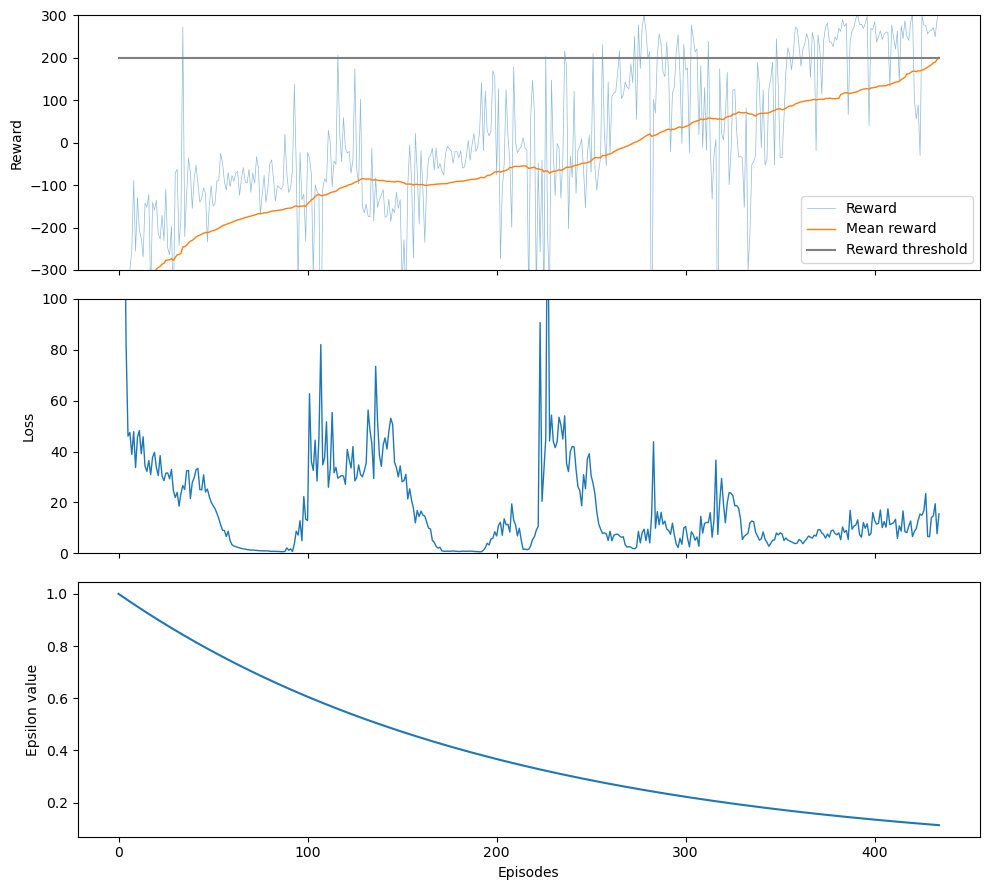

In [15]:
plot_training_results(dqn_training, env.spec.reward_threshold)